# Toy example for modelling a bayesian network in PYMC

I am currently attempting to model a bayesian network for determining the risk of a disease. The following is a minimal dummy example of what I need to get working in order to build a much larger network.  

The network can be represented by the following relationships:  

risk_factor -> expression_of_risk_factor -> disease   
direct_cause -> disease

These variables can take the following values:  
- risk_factor ~ [0,1]  
- expression_of_risk_factor ~ [0,1,2] (equivalent to ['low', 'medium', 'high'])
- direct_cause -> [0,1]  
- disease -> [0,1]  

The network will be trained on a dataset containing all the variables. Ultimately, the model will be used to determine the risk of `disease` given an incomplete set of observed data for a single row of data.

E.g. p(disease|risk_factor=0, direct_cause=1).

# Imports

In [2]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Data

I have generated a small dummy dataset which includes the causal relationships described above.

This is the data that will be used to train the model.

In [3]:
df = pd.read_csv("toy_dummy_data.csv", index_col=0)
df

,direct_cause,risk_factor,expression_of_risk_factor,disease
0,0,0,0,0
1,1,1,2,1
2,1,0,1,0
3,1,0,1,1
4,1,0,0,0
...,...,...,...,...
995,1,0,1,0
996,1,0,2,0
997,1,1,1,1
998,1,0,0,1


The prevalence of the disease in the data is very different given different features. 

In [3]:
high_risk_prevalence = df[
    (df["risk_factor"] == 1)
    & (df["expression_of_risk_factor"] == 2)
    & (df["direct_cause"] == 1)
].disease.mean()
low_risk_prevalence = df[
    (df["risk_factor"] == 0)
    & (df["expression_of_risk_factor"] == 0)
    & (df["direct_cause"] == 0)
].disease.mean()
print("high_risk_prevalence:", high_risk_prevalence)
print("low_risk_prevalence:", low_risk_prevalence)

high_risk_prevalence: 0.8942307692307693
low_risk_prevalence: 0.1111111111111111


# Define the model

Notes:  
- For each node, a data container, a prior, and the node itself are defined.
- The shape of the node is explicitly stated as the shape of the data. This allows the same model to be used on difference datasets (e.g. training/validation/prediction).

In [4]:
def get_model():
    with pm.Model() as model:

        # data containers for each node
        direct_cause_data = pm.Data(
            "direct_cause_data", df["direct_cause"], mutable=True
        )
        risk_factor_data = pm.Data("risk_factor_data", df["risk_factor"], mutable=True)
        disease_data = pm.Data("disease_data", df["disease"], mutable=True)
        expression_of_risk_factor_data = pm.Data(
            "expression_of_risk_factor_data",
            df["expression_of_risk_factor"],
            mutable=True,
        )

        # flat priors
        p_direct_cause = pm.Beta("p_direct_cause", alpha=2, beta=2)
        p_risk_factor = pm.Beta("p_risk_factor", alpha=2, beta=2)
        p_disease_given_direct_cause_expression_of_risk_factor = pm.Beta(
            "p_disease_given_direct_cause_expression_of_risk_factor",
            alpha=2,
            beta=2,
            shape=(2, 3),
        )
        p_expression_of_risk_factor_given_risk_factor = pm.Dirichlet(
            "p_expression_of_risk_factor_given_risk_factor", a=np.ones((2, 3))
        )

        # observed variables
        risk_factor_observed = pm.Bernoulli(
            "risk_factor_observed",
            p=p_risk_factor,
            observed=risk_factor_data,
            shape=risk_factor_data.shape,
        )
        direct_cause_observed = pm.Bernoulli(
            "direct_cause_observed",
            p=p_direct_cause,
            observed=direct_cause_data,
            shape=direct_cause_data.shape,
        )
        expression_of_risk_factor_observed = pm.Categorical(
            "expression_of_risk_factor_observed",
            p=p_expression_of_risk_factor_given_risk_factor[risk_factor_observed],
            shape=expression_of_risk_factor_data.shape,
            observed=expression_of_risk_factor_data,
        )
        disease_observed = pm.Bernoulli(
            "disease_observed",
            p=p_disease_given_direct_cause_expression_of_risk_factor[
                direct_cause_observed, expression_of_risk_factor_observed
            ],
            observed=disease_data,
            shape=disease_data.shape,
        )
    return model

In [5]:
model = get_model()

/Users/annaharding/Documents/spandanna-repos/bayes-net-pymc-example/.venv/lib/python3.12/site-packages/pymc/data.py:416: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


# DAG

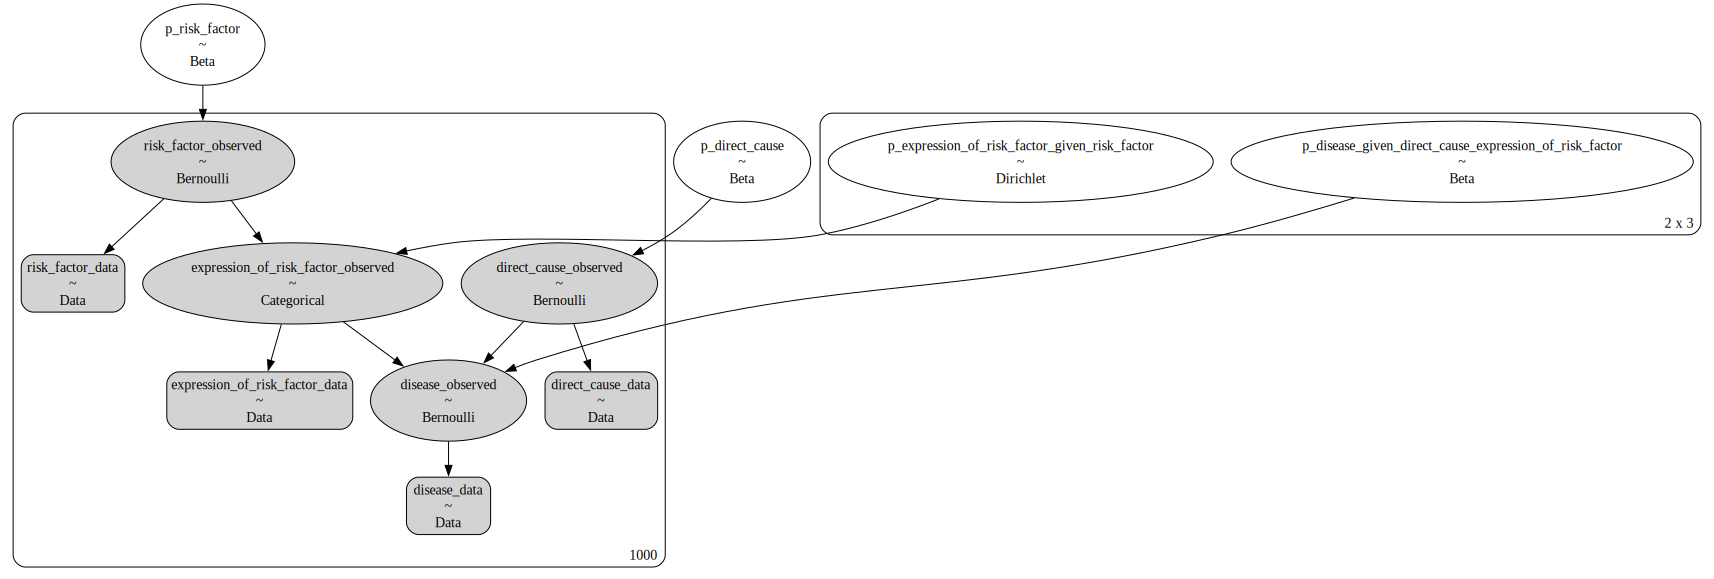

In [6]:
pm.model_to_graphviz(model)

# Sample the model

Sample the prior, prior predictive and posterior. The model seems to sample well.

In [7]:
with model:
    trace = pm.sample_prior_predictive(1000)
    trace.extend(pm.sample(1000))
trace

Sampling: [direct_cause_observed, disease_observed, expression_of_risk_factor_observed, p_direct_cause, p_disease_given_direct_cause_expression_of_risk_factor, p_expression_of_risk_factor_given_risk_factor, p_risk_factor, risk_factor_observed]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_direct_cause, p_risk_factor, p_disease_given_direct_cause_expression_of_risk_factor, p_expression_of_risk_factor_given_risk_factor]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

The summary looks good - the priors are now looking similar to the observations in the data.

In [8]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p_direct_cause,0.598,0.016,0.568,0.627,0.000,0.0,8792.0,2395.0,1.0
"p_disease_given_direct_cause_expression_of_risk_factor[0, 0]",0.130,0.024,0.085,0.174,0.000,0.0,9776.0,2712.0,1.0
"p_disease_given_direct_cause_expression_of_risk_factor[0, 1]",0.219,0.041,0.145,0.295,0.000,0.0,8398.0,2669.0,1.0
"p_disease_given_direct_cause_expression_of_risk_factor[0, 2]",0.579,0.048,0.488,0.667,0.001,0.0,8976.0,2986.0,1.0
"p_disease_given_direct_cause_expression_of_risk_factor[1, 0]",0.191,0.024,0.151,0.240,0.000,0.0,8912.0,2489.0,1.0
"p_disease_given_direct_cause_expression_of_risk_factor[1, 1]",0.266,0.035,0.204,0.331,0.000,0.0,9643.0,2764.0,1.0
"p_disease_given_direct_cause_expression_of_risk_factor[1, 2]",0.885,0.024,0.840,0.929,0.000,0.0,8893.0,3141.0,1.0
"p_expression_of_risk_factor_given_risk_factor[0, 0]",0.592,0.017,0.559,0.624,0.000,0.0,8786.0,2492.0,1.0
"p_expression_of_risk_factor_given_risk_factor[0, 1]",0.303,0.016,0.274,0.335,0.000,0.0,8783.0,2753.0,1.0
"p_expression_of_risk_factor_given_risk_factor[0, 2]",0.105,0.011,0.084,0.124,0.000,0.0,9787.0,2773.0,1.0


The plot confirms that the posteriors are different from the priors.

/Users/annaharding/Documents/spandanna-repos/bayes-net-pymc-example/.venv/lib/python3.12/site-packages/arviz/plots/distcomparisonplot.py:161: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of subplots to plot (42), generating only 39 plots
  warnings.warn(


array([[<Axes: >, <Axes: >, <Axes: xlabel='p_direct_cause'>],
       [<Axes: >, <Axes: >,
        <Axes: xlabel='p_disease_given_direct_cause_expression_of_risk_factor\n0, 0'>],
       [<Axes: >, <Axes: >,
        <Axes: xlabel='p_disease_given_direct_cause_expression_of_risk_factor\n0, 1'>],
       [<Axes: >, <Axes: >,
        <Axes: xlabel='p_disease_given_direct_cause_expression_of_risk_factor\n0, 2'>],
       [<Axes: >, <Axes: >,
        <Axes: xlabel='p_disease_given_direct_cause_expression_of_risk_factor\n1, 0'>],
       [<Axes: >, <Axes: >,
        <Axes: xlabel='p_disease_given_direct_cause_expression_of_risk_factor\n1, 1'>],
       [<Axes: >, <Axes: >,
        <Axes: xlabel='p_disease_given_direct_cause_expression_of_risk_factor\n1, 2'>],
       [<Axes: >, <Axes: >,
        <Axes: xlabel='p_expression_of_risk_factor_given_risk_factor\n0, 0'>],
       [<Axes: >, <Axes: >,
        <Axes: xlabel='p_expression_of_risk_factor_given_risk_factor\n0, 1'>],
       [<Axes: >, <Axes: >,


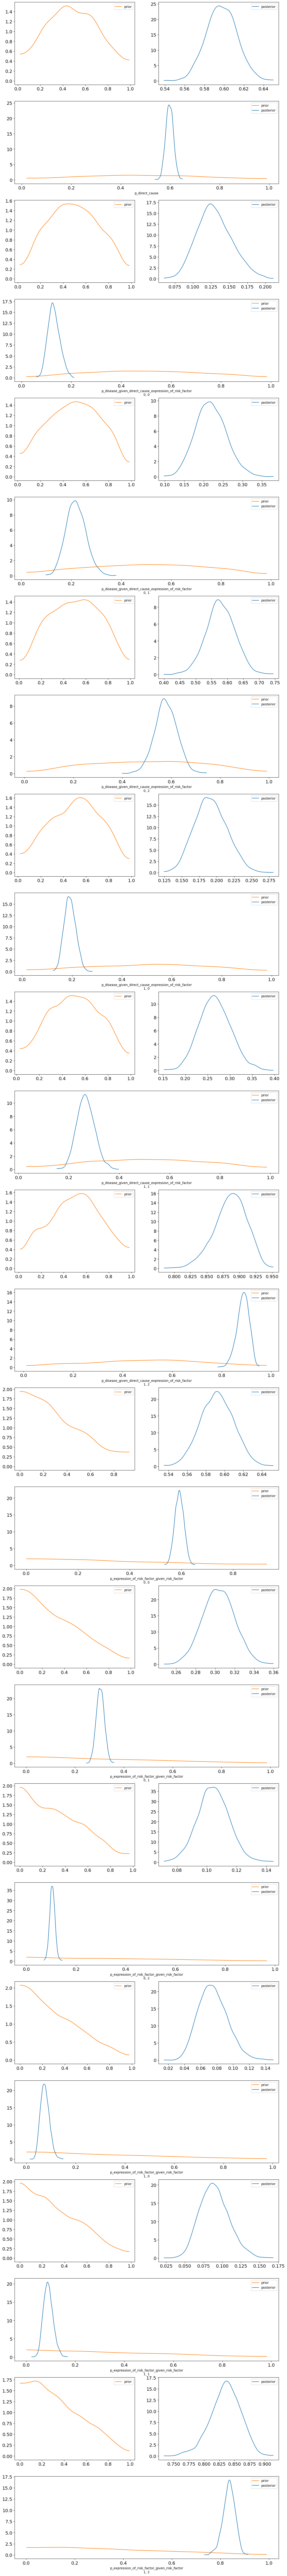

In [8]:
pm.plot_dist_comparison(trace)

However, the trace only contains posteriors for the probabilities (what I thought were the priors) and not for the observed nodes. This presents a problem when trying to generate a prediction for `disease` based on observing the other nodes.

In [10]:
trace.posterior.data_vars

Data variables:
    p_direct_cause                                          (chain, draw) float64 32kB ...
    p_disease_given_direct_cause_expression_of_risk_factor  (chain, draw, p_disease_given_direct_cause_expression_of_risk_factor_dim_0, p_disease_given_direct_cause_expression_of_risk_factor_dim_1) float64 192kB ...
    p_expression_of_risk_factor_given_risk_factor           (chain, draw, p_expression_of_risk_factor_given_risk_factor_dim_0, p_expression_of_risk_factor_given_risk_factor_dim_1) float64 192kB ...
    p_risk_factor                                           (chain, draw) float64 32kB ...

# Predict on unseen data

To predict on unseen data, the new inference data overwrites the training data, and the posterior predictive is sampled for the node we are trying to predict.

In [11]:
def get_prediction(
    direct_cause: int,
    risk_factor: int,
    expression_of_risk_factor: int,
    trace: az.InferenceData,
) -> az.InferenceData:
    with get_model():
        pm.set_data(
            {
                "direct_cause_data": [direct_cause],
                "risk_factor_data": [risk_factor],
                "disease_data": np.ma.masked_values(
                    np.array([-1]), value=-1
                ),  # masked array for node I want to predict
                "expression_of_risk_factor_data": [expression_of_risk_factor],
            }
        )
        return pm.sample_posterior_predictive(
            trace, var_names=["disease_observed"], predictions=True
        )

In [12]:
low_risk_pred = get_prediction(0, 0, 0, trace)
high_risk_pred = get_prediction(1, 1, 2, trace)

/Users/annaharding/Documents/spandanna-repos/bayes-net-pymc-example/.venv/lib/python3.12/site-packages/pymc/data.py:416: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [direct_cause_observed, disease_observed, expression_of_risk_factor_observed, risk_factor_observed]


Output()

/Users/annaharding/Documents/spandanna-repos/bayes-net-pymc-example/.venv/lib/python3.12/site-packages/pymc/data.py:416: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [direct_cause_observed, disease_observed, expression_of_risk_factor_observed, risk_factor_observed]


Output()

These predictions do not seem to be conditioned on the new observed data points.

In [13]:
low_risk_pred.predictions.disease_observed.mean()

<xarray.DataArray 'disease_observed' ()> Size: 8B
array(0.3355)

In [14]:
high_risk_pred.predictions.disease_observed.mean()

<xarray.DataArray 'disease_observed' ()> Size: 8B
array(0.34575)